# Salary Analytics

This repository consists of conducting analysis on publicaly submitted salaries. The data was gathered and inspired by [Christen Nino De Guzman](https://www.linkedin.com/in/christenndg/) on her linkedin post about wage transparency. You can find the post [here](https://www.linkedin.com/feed/update/urn:li:activity:6883141659610234880/) and the associated csv [here](https://docs.google.com/spreadsheets/d/19h0WT9Xjf9ncNmJDWpd8fzz7YnB37nemDnxKSO0EE8o/edit#gid=1664289965). She advocated this on her linkedin community and it gained a lot of traction, nearly 60,000 people have anonomously submitted their total compensation breakdown, gender, age range, etc. The purpose of this article is to strictly do an analysis on the data retried. The article will consist of a few different segments as outlined below:

**Table of Contents**
- Data Retrieval
- Data Cleaning
- Analysis & Visualization
- Modelling
- Concluding Remarks
- Resources

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as pt

sns.set()

In [2]:
# constants
# source = https://docs.google.com/spreadsheets/d/19h0WT9Xjf9ncNmJDWpd8fzz7YnB37nemDnxKSO0EE8o/edit#gid=1664289965
file_path = './data/anon_salary.csv'

## Import Data

In [3]:
d = pd.read_csv(file_path)
d.shape

(59688, 22)

## Clean Data

During the cleaning components, we're not going to really aim for perfection as there's just too much data to parse through manually and too many individual edge cases which would act as outliers. We're aiming to clean the masses of the results that users have submitted. So the cleaning portion will most definetly not be perfect, but when dealing with a large volume of user submitted data without any options / restrictions in place for the submissions, it becomes almost impossible to have **perfectly** cleaned data. In this section we'll begin by renaming the columns to remove any fluf and wierd wording in them.

In [4]:
rename_cols = {
    'Timestamp' : 'timestamp',
    'Country' : 'country',
    'Age Range' : 'age_range',
    'Highest Level of Education Received' : 'max_edu',
    'Company Name' : 'org',
    'Years of Experience' : 'yoe',
    'Closest Major City and State (e.g. Santa Clara, CA)' : 'loc_city',
    'Annual Base Salary (if hourly, please convert to annual)' : 'annual_wage',
    'How many vacation days are you given per year?' : 'vacation_days_yearly',
    'How many sick days are you given per year?' : 'sick_days_yearly',
    'Do you openly discuss salary with your colleagues?' : 'open_wage_discussions',
    'How many months Maternity or Paternity does your company offer?' : 'maternity_leave_months',
    'Diverse Identity (Optional)' : 'ethnicity',
    'Currency (USD, CAD, etc)' : 'currency',
    'Gender (optional)' : 'gender',
    'Annual Bonus' : 'bonus',
    'Annual Average of RSUs' : 'avg_rsu',
    'Signing Bonus (if none, leave blank)' : 'signing_bonus',
    'Job Title' : 'job_title',
    'How many days per week are you required to work onsite/in the office?' : 'days_per_week_in_office'
}

d.rename(columns = rename_cols, inplace = True)
d.drop(columns = ['Unnamed: 20'], inplace = True)

In [5]:
curr_dct = {
    # I'm aware that dollars and $ can be across many different currencies, I'm making a generalized assumption
    'usd' : ['us dollar', 'us dollars', 'usda', 'usdp', 'dollars', '$', 'usa', 'uds', 'ysd', 'uss'],  
    'cad' : ['can', 'canadian', 'caf', 'canada'],
    'eur' : ['euro', 'euros', 'eu',],
    'gbp' : ['pound', 'pound sterling', 'pounds', 'british pounds', 'british pound', 'gbp £']
}

def clean_currency(cur, curr_dct = curr_dct):
    '''
    Will clean the currency column 
    '''
    cur = str(cur).lstrip().rstrip().strip().lower()
    for k,v in curr_dct.items():
        if cur in v:
            return k

    if cur == 'nan' or cur == 'n/a' or cur == '-':
        return np.nan
    return cur

In [6]:
def clean_wage(wage):
    '''
    Will clean the user input wage to be an integer
    '''
    wage=str(wage).lower()
    wage = wage.replace('$','').replace(' ', '').replace(',', '').replace('cad', '').replace('usd','').replace('()','').replace('k', '000')
    try:
        return int(wage)
    except:
        return np.nan

In [7]:
d['annual_wage'] = d['annual_wage'].apply(lambda x : clean_wage(x))

In [8]:
d['currency'] = d['currency'].apply(lambda x : clean_currency(x))

In [9]:
d['max_edu'].value_counts()

Bachelor's Degree                                             36936
Master's Degree                                               10082
Some College credit, no degree                                 4274
Associate Degree                                               1939
High School Graduate, Diploma or the equivalent (e.g. GED)     1786
Doctorate Degree                                               1205
Trade, Technical, Vocational Training                           737
Professional Degree                                             731
Some High School, No Diploma                                    207
No Schooling Completed                                          126
Name: max_edu, dtype: int64

In [10]:
def clean_org(org):
    '''
    This will clean the organization section. It will return np.nan if the user has not provided
    their organization, otherwise it will return the lowered organization passed
    '''
    
    na_list = ['prefer not to say', 'N/a', '-', 'nan', 'anon', 'anonymous', 'Prefer not to say']
    if str(org).lower().lstrip().rstrip() in na_list:
        return np.nan
    return str(org).rstrip().lstrip().lower()

d['org'] = d['org'].apply(clean_org)

In [11]:
def clean_loc_city(city):
    city_dct = {
        'nyc' : ['new york, ny', 'nyc', 'new york', 'new york city, ny', 'new york city', 'new york, new york', 'ny'],
        'la' : ['los angeles, ca', 'los angeles'],
        np.nan : ['nan', 'none', '-', 'n/a'],
        'toronto' : ['toronto', 'toronto, ontario', 'toronto, canada', 'toronto, on', 'toronto, ca']
    }
    for k,v in city_dct.items():
        if str(city).lower().lstrip().rstrip() in v:
            return k
    cleaned_city = str(city).split(',')[0]
    return cleaned_city.lower().lstrip().rstrip()

d['loc_city'] = d['loc_city'].apply(clean_loc_city)

In [12]:
def clean_country(country):
    country_dct = {
        'usa' : [
            'united stayes', 'united statea', 'united stares', 'united states', 'unites states', 'united state', 
            'california', 'new york', 'us', 'ny', 'united statws',  'usa', 'united states', 'united states of america',
            'america', 'u.s.a.', 'u.s.a', 'u.s', 'u.s.', 'ny', 'united stated', 'los angeles', 'untied states',
            'united statss', 'united sates', 'la', 'sacramento', 'ysa'
        ],
        'canada' : ['canada', 'ca', 'can'],
        'united kingdom' : ['united kingdom', 'uk', ''],
        np.nan : ['nan', 'n/a', 'none', '-']
    }
    country = str(country).lower().lstrip().rstrip()
    for k,v in country_dct.items():
        if country in v:
            return k
    return country
d['country'] = d['country'].apply(clean_country)

In [13]:
def clean_job(job):
    job_dct = {
        'swe' : ['swe', 'software engineer', ''],
        'nurse' : ['rn', 'registered nurse', 'nurse'],
        'data scientist' : ['data science', 'data scientist'],
        np.nan : ['nan', '-', 'none']
    }
    job = str(job).lstrip().rstrip().lower()
    for k,v in job_dct.items():
        if job in v:
            return k
    return job
d['job_title'] = d['job_title'].apply(clean_job)

In [14]:
def clean_gender(gender):
    gender_dct = {
        'female' : ['female'],
        'male' : ['male'],
        np.nan : ['prefer not to say', 'n/a', '-', "you shouldn't have included this free text field eh?"],
        'non-binary' : ['non-binary', 'non binary', 'nb', 'nonbinary'],
        'trans' : ['trans', 'transgender fem', 'genderqueer, transmasculine', 'trans female', 'trans man', 'trans male']
    }
    gender = str(gender).lower().lstrip().rstrip()
    for k,v in gender_dct.items():
        if gender in v:
            return k
        if 'binary' in gender:
            return 'non-binary'
    return 'other'
d['gender'] = d['gender'].apply(clean_gender)

In [15]:
def clean_yoe(yoe):
    yoe = str(yoe).lstrip().rstrip()
    if yoe == 'nan':
        return np.nan
    elif yoe == '20+':
        return '20+'
    else:
        try:
            return int(yoe)
        except:
            return yoe
d['yoe'] = d['yoe'].apply(clean_yoe)

In [16]:
d['signing_bonus'] = d['signing_bonus'].apply(clean_wage)
d['bonus'] = d['bonus'].apply(clean_wage)

In [17]:
def clean_sick_days(days):
    sick_dct = {
        'unlim' : ['as many as i want', 'as many as i need', 'infinite', 'unlimited', '🚩unlimited', 'no limit', 'pto', 'unlimited (kind of)', 'unlimited pto', '"unlimited"'],
        np.nan : ['none', 'nan', 'n/a', '-', '?', 'na', 'idk', 'not sure', 'unsure'],
        10 : ['2 weeks', '10 days', '14 days'],
        5 : ['1 week', '5 days', '7 days', '40 hours'],
        15 : ['3 weeks', '15 days', '21 days'],
        20 : ['4 weeks', '20 days'],
        25 : ['5 weeks', '25 days'],
        30 : ['30 days', '6 weeks']
    }
    days = str(days).lower().lstrip().rstrip().replace('"', '').replace('"', '')
    for k,v in sick_dct.items():
        if days in v:
            return k
    try:
        return int(days)
    except:
        return days
    
d['sick_days_yearly'] = d['sick_days_yearly'].apply(clean_sick_days)
d['vacation_days_yearly'] = d['vacation_days_yearly'].apply(clean_sick_days)

In [18]:
def clean_open_discussions(disc):
    disc_dct = {
        'yes' : ['yes', 'ya', 'yeah'],
        'no'  : ['no', 'nope', 'never']
    }
    
    disc = str(disc).lower().lstrip().rstrip()
    for k,v in disc_dct.items():
        for val in v:
            if val in disc:
                return k
    return 'other'
d['open_wage_discussions'] = d['open_wage_discussions'].apply(clean_open_discussions)

In [19]:
def clean_ethnicity(eth):
    eth_dct = {
        'caucasian' : ['white', 'caucasian', 'white female', 'white male'],
        'african american' : ['black', 'african', 'black american', 'black/african american', 'african american', 'black woman', 'african-american', 'black male', 'black man', 'black female'],
        'hispanic' : ['hispanic', 'latina', 'latino', 'latinx', 'mexican-american', 'latino/hispanic',  'mexican', 'mexico', 'mexican american', 'latin'],
        'asian' : ['asian', 'asian american', 'south asian', 'asian-american', 'korean', 'indian american', 'vietnamese', 'east asian', 'asian indian', 'asian woman', 'filipino', 'filipina', 'indian', 'chinese'],
        'middle eastern' : ['middle eastern', 'arab', 'pakistani'],
        'native' : ['native american', 'native', 'indigenous']
    }
    eth = str(eth).lower().lstrip().rstrip()
    
    for k,v in eth_dct.items():
        if eth in v:
            return k
    return 'unknown'

d['ethnicity'] = d['ethnicity'].apply(clean_ethnicity)

In [20]:
d['avg_rsu'] = d['avg_rsu'].apply(clean_wage)

In [21]:
def clean_mat_leave(mat):
    mat_dct = {
        np.nan : ['none', 'not sure', 'unsure','no', 'no idea', '?', 'idk', 'unknown', 'n/a', '-', "don't know", '0'],
        0.5 : ['2 weeks'],
        1 : ['1', '1 month'],
        1.5 : ['6 weeks', '1.5'],
        2 : ['2', '2 months', '8 weeks'],
        3 : ['3', '3 months', '12 weeks'],
        4 : ['4', '4 months', '16 weeks'],
        5 : ['5', '5 months', '20 weeks'],
        6 : ['6', '6 months', '24 weeks'],
        float('inf') : ['unlimited']
    }
    mat = str(mat).lower().lstrip().rstrip()
    for k,v in mat_dct.items():
        if mat in v:
            return k
    return 'unknown'

d['maternity_leave_months'] = d['maternity_leave_months'].apply(clean_mat_leave)

In [22]:
def clean_industry(ind):
    ind_dct = {
        'tech' : ['tech'],
        'finance' : ['fin tech', 'finance', 'fintech', 'financial services'],
        'heath care' : ['healthcare', 'health care', 'HospTechalTechy', 'healthcare tech'],
        'non profit' : ['nonproftech', 'non proftech', 'non profit']
    }
    ind = str(ind).lower().lstrip().rstrip()
    for k,v in ind_dct.items():
        if ind in v:
            return k
    return ind

d['Industry'] = d['Industry'].apply(clean_industry)

## Analysis / Visualization

Questions to answer: 
- convert wages, signing bonus, rsu to usd via currency
- average wages per ethnic groups
- average wages per gender
- What is the average income per years of experience
- what is the average income per age group
- which industries have the highest average salary per yoe
- which locations pay better for same positions
- which organizations pay the most
- how much does level of education translate to income, 

In [48]:
d.columns

Index(['timestamp', 'age_range', 'yoe', 'Industry', 'job_title', 'org',
       'max_edu', 'loc_city', 'country', 'annual_wage', 'bonus', 'avg_rsu',
       'signing_bonus', 'currency', 'vacation_days_yearly', 'sick_days_yearly',
       'days_per_week_in_office', 'open_wage_discussions',
       'maternity_leave_months', 'gender', 'ethnicity'],
      dtype='object')

In [53]:
len(str(22))

2

In [54]:
len(set(str(22)))

1

In [47]:
d.head()

,timestamp,age_range,yoe,Industry,job_title,org,max_edu,loc_city,country,annual_wage,...,avg_rsu,signing_bonus,currency,vacation_days_yearly,sick_days_yearly,days_per_week_in_office,open_wage_discussions,maternity_leave_months,gender,ethnicity
0,12/5/2021 11:57:44,26-29,6,heath care,nurse,penn medicine,Bachelor's Degree,philadelphia,usa,85000,...,0.0,NaN,usd,10,4,3,yes,1,female,unknown
1,12/6/2021 19:31:12,30-33,13,retail banking,financial center manager,bank of america,"Some College credit, no degree",san diego,usa,71000,...,NaN,NaN,usd,15,10,"None, I work fully remote",no,1.5,female,unknown
2,12/6/2021 19:32:36,22-25,1,finance,sdr,NaN,Bachelor's Degree,san francisco california,usa,97000,...,10000.0,NaN,usd,30,15,"None, I work fully remote",yes,0.5,female,unknown
3,12/6/2021 19:34:44,22-25,2,marketing/data/business,associate business system analyst,epsilon,Bachelor's Degree,dallas,usa,57000,...,NaN,NaN,usd,21,14,"None, I work fully remote",yes,unknown,female,unknown
4,12/6/2021 19:39:18,22-25,1,retail,swe,target,Bachelor's Degree,minneapolis,usa,80000,...,NaN,NaN,usd,15,unlim,"None, I work fully remote",yes,unknown,female,unknown


In [27]:
us_df = d[d['currency'] == 'usd'].copy()

In [25]:
def generate_hist():
    pass

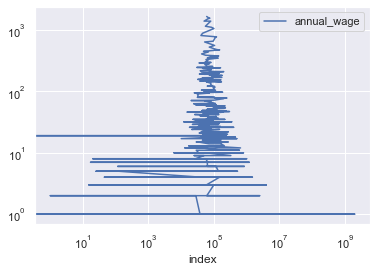

In [46]:
us_df[['annual_wage']].dropna().annual_wage.value_counts().reset_index().plot(x = 'index', y = 'annual_wage', kind = 'line')
plt.yscale('log')
plt.xscale('log')

In [68]:
for age, d in d.groupby('age_range'):
    avg_wage = d['annual_wage'].values.mean()
    print(age, avg_wage, d.shape)

58+ nan (52, 21)


In [71]:
for age, d in d.groupby('yoe'):
    avg_wage = d['annual_wage'].values.mean()
    print(age, avg_wage, d.shape)

1 400494160.0 (5, 21)
2 nan (2, 21)
3 nan (1, 21)
5 81000.0 (1, 21)
7 58000.0 (1, 21)
10 nan (2, 21)
13 20000.0 (1, 21)
15 127000.0 (4, 21)
16 95000.0 (2, 21)
18 40000.0 (1, 21)
20+ 172515.65625 (32, 21)


In [70]:
d.head()

,timestamp,age_range,yoe,Industry,job_title,org,max_edu,loc_city,country,annual_wage,...,avg_rsu,signing_bonus,currency,vacation_days_yearly,sick_days_yearly,days_per_week_in_office,open_wage_discussions,maternity_leave_months,gender,ethnicity
209,12/6/2021 21:16:24,58+,20+,medical devices,biostatistician,johnson and johnson,Master's Degree,chicago,usa,196000,...,0.0,0.0,usd,15,NaN,5,no,NaN,female,unknown
319,12/6/2021 21:54:12,58+,20+,heath care,nurse,kaiser permanente,Associate Degree,oakland,usa,200000,...,NaN,NaN,NaN,25,12,5,no,3,female,unknown
549,12/6/2021 22:27:05,58+,15,education,public information officer,large school district in new jersey,Master's Degree,newark,usa,85000,...,NaN,NaN,usd,30,12,5,no,unknown,female,unknown
639,12/6/2021 22:36:15,58+,20+,hvac services,controller,NaN,Bachelor's Degree,milwaukee wi,usa,112000,...,NaN,NaN,usd,20,"not tracked, whatever i need",5,no,unknown,female,unknown
1322,12/6/2021 23:30:06,58+,1,heath care,member service advisor,s,Bachelor's Degree,austin,usa,37000,...,NaN,0.0,usd,unlim,unlim,NaN,no,unknown,female,unknown


In [5]:
d['is_ds'] = d['job_title'].apply(lambda x : [True if str(x).lower() in ['data', 'science', 'scientist', 'research'] else False][0])

In [32]:
d[d['is_ds']==True].parsed_annual_wage.max()

140000